In [1]:
from acr.utils import SOM_BLUE, NNXR_GRAY

MAIN_EXP = 'swi'
SUBJECT_TYPE = 'som'
MAIN_COLOR = SOM_BLUE

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap

def modified_coolwarm_low(low="#1a9850", *, N=256, name="coolgreen"):
    """
    Return a version of 'coolwarm' where the *lower* half fades
    into `low` (instead of blue).

    Parameters
    ----------
    low : str or tuple
        Target low-end colour (e.g. "#1a9850" for green).
    N : int
        Number of discrete samples pulled from the base map (256 by default).
    name : str
        Name given to the resulting colormap object.

    Returns
    -------
    matplotlib.colors.ListedColormap
    """
    base = mpl.cm.get_cmap("coolwarm", N)           # original map, N samples
    colors = base(np.linspace(0, 1, N))             # RGBA array, shape (N,4)
    mid = N // 2                                    # neutral grey index
    lo_rgba = mpl.colors.to_rgba(low)

    # Replace the lower half [0 : mid] with a linear blend: `low` → mid-grey
    t = np.linspace(0, 1, mid + 1)[:, None]         # 0 → 1 from low to centre
    colors[:mid + 1] = (1 - t) * lo_rgba + t * colors[mid]

    return ListedColormap(colors, name=name)

In [3]:

#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import pingouin as pg
from scipy.stats import shapiro, normaltest
import numpy as np
import kdephys as kde

import warnings
warnings.filterwarnings('ignore')

from cmcrameri import cm as scm

probe_ord = ['NNXr', 'NNXo']
hue_ord = [NNXR_GRAY, MAIN_COLOR]

from acr.plots import lrg
plt.rcdefaults()
lrg()
plt.rcParams['xtick.bottom'] = False
#--------------------------------- Import Publication Functions ---------------------------------#
pu = acr.utils.import_publication_functions('/home/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
dag = acr.utils.import_publication_functions('/home/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from acr.utils import *

In [4]:
subjects, exps = pu.get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)

In [5]:
notebook_figure_root = f'{pu.PAPER_FIGURE_ROOT}/synchrony/sttc'

In [6]:
muas = {}
for subject, exp in zip(subjects, exps):
        mua = acr.mua.load_concat_peaks_df(subject, exp)
        muas[subject] = mua

In [7]:
full_hyps = {}
hyp_dicts = {}
for subject, exp in zip(subjects, exps):
    full_hyps[subject] = acr.io.load_hypno_full_exp(subject, exp)
    hyp_dicts[subject] = acr.hypnogram_utils.create_acr_hyp_dict(subject, exp, true_stim=True, duration='3600s')

In [8]:
bmtx = {}
for subject in muas.keys():
    bmtx[subject] = {}
    for condition in ['early_bl', 'circ_bl', 'stim', 'rebound']:
        print(subject, condition)
        hypno_to_use = hyp_dicts[subject][condition]
        bmtx[subject][condition] = acr.sync.dual_probe_sttc(muas[subject], hypno_to_use, delta_ms=5)

ACR_25 early_bl
ACR_25 circ_bl
ACR_25 stim
ACR_25 rebound
ACR_26 early_bl
ACR_26 circ_bl
ACR_26 stim
ACR_26 rebound
ACR_29 early_bl
ACR_29 circ_bl
ACR_29 stim
ACR_29 rebound
ACR_30 early_bl
ACR_30 circ_bl
ACR_30 stim
ACR_30 rebound
ACR_35 early_bl
ACR_35 circ_bl
ACR_35 stim
ACR_35 rebound
ACR_37 early_bl
ACR_37 circ_bl
ACR_37 stim
ACR_37 rebound
ACR_39 early_bl
ACR_39 circ_bl
ACR_39 stim
ACR_39 rebound
ACR_40 early_bl
ACR_40 circ_bl
ACR_40 stim
ACR_40 rebound
ACR_41 early_bl
ACR_41 circ_bl
ACR_41 stim
ACR_41 rebound
ACR_44 early_bl
ACR_44 circ_bl
ACR_44 stim
ACR_44 rebound


In [9]:
for subject in muas.keys():
    hypno_to_use = acr.hypnogram_utils.get_full_bl_hypno(full_hyps[subject], state='NREM')
    bmtx[subject]['full_bl'] = acr.sync.dual_probe_sttc(muas[subject], hypno_to_use, delta_ms=5)

In [10]:
nan_out_chans = False
scd = {}
scd['ACR_37'] = [3, 15]
scd['ACR_35'] = [3]
scd['ACR_29'] = [0, 1]
conds = ['rebound', 'full_bl', 'early_bl', 'circ_bl', 'stim']
if nan_out_chans:
    for subject in scd.keys():
        for probe in ['NNXo', 'NNXr']:
            for condition in conds:
                old_dat = bmtx[subject][condition][probe]
                new_dat = acr.sync.mask_bad_channels(old_dat, scd[subject])
                bmtx[subject][condition][probe] = new_dat

In [11]:
mtx_avgs = []
for subject in bmtx.keys():
    for cond in bmtx[subject].keys():
        for probe in bmtx[subject][cond].keys():
            for i, bout_mat in enumerate(bmtx[subject][cond][probe]):
                avg = np.nanmean(bout_mat)
                mtx_avg = pd.DataFrame(
                    {
                        'condition': cond,
                        'bout_ix': i,
                        'avg': avg,
                        'probe': probe,
                        'subject': subject
                    },
                    index=[0])
                mtx_avgs.append(mtx_avg)
mtxdf = pd.concat(mtx_avgs)
mtxdf = pl.from_dataframe(mtxdf)
mtxdf = dag.relativize_df(mtxdf, 'condition', 'full_bl', 'mean', 'avg', ['subject', 'probe'])
mtxmean = mtxdf.cdn('rebound').group_by(['subject', 'probe']).agg(pl.col('avg_rel').mean())
mtxmean = mtxmean.sort(['subject', 'probe'])

In [12]:
# average across bouts (i.e. keep channel-pair info) for all conditions
cond_avgs = {}
for subject in bmtx.keys():
    cond_avgs[subject] = {}
    for cond in bmtx[subject].keys():
        cond_avgs[subject][cond] = {}
        for probe in bmtx[subject][cond].keys():
            cond_avgs[subject][cond][probe] = acr.sync.average_sttc_matrices(bmtx[subject][cond][probe])

In [13]:
# make the averaged condition-matrices all relative to the full baseline - SIMPLE RATIO
reb_rel_avgs = {}
for subject in bmtx.keys():
    reb_rel_avgs[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        full_bl_mtx = cond_avgs[subject]['full_bl'][probe]
        reb_mtx = cond_avgs[subject]['rebound'][probe]
        rel_mtx = reb_mtx / full_bl_mtx
        reb_rel_avgs[subject][probe] = rel_mtx

In [14]:
# make the averaged condition-matrices all relative to the full baseline - FISHER DIFFERENCE
reb_rel_avgs = {}
for subject in bmtx.keys():
    reb_rel_avgs[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        full_bl_mtx = cond_avgs[subject]['full_bl'][probe]
        reb_mtx = cond_avgs[subject]['rebound'][probe]
        eps = 1e-6
        full_bl_mtx = np.arctanh(np.clip(full_bl_mtx, -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(reb_mtx, -1+eps, 1-eps))
        rel_mtx = reb_mtx - full_bl_mtx
        reb_rel_avgs[subject][probe] = rel_mtx

In [15]:
#obvious outlier/artifactual pairs
reb_rel_avgs['ACR_29']['NNXo'][5, 6] = np.nan
reb_rel_avgs['ACR_29']['NNXr'][5, 6] = np.nan

reb_rel_avgs['ACR_40']['NNXo'][2, 3] = np.nan
reb_rel_avgs['ACR_40']['NNXr'][2, 3] = np.nan

reb_rel_avgs['ACR_44']['NNXo'][5, 6] = np.nan
reb_rel_avgs['ACR_44']['NNXr'][5, 6] = np.nan
reb_rel_avgs['ACR_44']['NNXo'][13, 14] = np.nan
reb_rel_avgs['ACR_44']['NNXr'][13, 14] = np.nan

In [16]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False

(-0.022454761160518623, 0.0943437509069275)


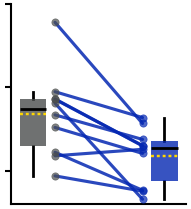

In [134]:
# better averaging method - first average each condition across bouts into a single matrix, then make each channel-pair value relative to its own channel-pair value from the baseline. Then average all of those channel-pairs into a single number.
fig_id = 'REBOUND_STTC_all_channel_average'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

nnxr = np.array([np.nanmean(reb_rel_avgs[subject]['NNXr']) for subject in reb_rel_avgs.keys()])
nnxo = np.array([np.nanmean(reb_rel_avgs[subject]['NNXo']) for subject in reb_rel_avgs.keys()])
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=(3.5, 4))
print(ax.get_ylim())
ax.set_ylim(-.02, 0.1)
ax.set_yticks([0.0, 0.05, 0.1])

f.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

In [136]:
# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats

shapiro_p-value: 0.17724960572415793
d,agostino_p-value: 0.4258978516579929
hedges g: 1.0837601942406176


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.853134,9,two-sided,0.003888,"[0.01, 0.04]",1.131573,13.317,0.888361


(-0.0639478232104098, 0.007122861033848873)


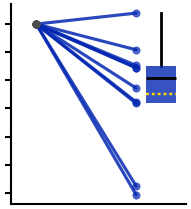

In [137]:
nnxr_norm = nnxr-nnxr
nnxo_norm = nnxo-nnxr

# better averaging method - first average each condition across bouts into a single matrix, then make each channel-pair value relative to its own channel-pair value from the baseline. Then average all of those channel-pairs into a single number.
fig_id = 'REBOUND_STTC_all_channel_average-NORMALIZED'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'


f, ax = acr.plots.gen_paired_boxplot(nnxr_norm, nnxo_norm, colors=[NNXR_GRAY, MAIN_COLOR], fsize=(3.5, 4), one_sided=True)
print(ax.get_ylim())
#ax.set_yticks([0.7, 0.8, 0.9, 1])
#ax.set_ylim(0.7, 1.01)

f.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# Matrix - Main Plots 

In [20]:
from matplotlib.colors import TwoSlopeNorm

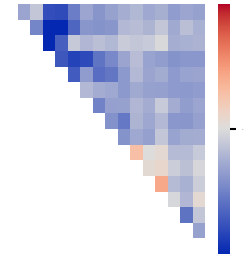

In [139]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

#cmap = kde.plot.main.custom_diverging_cmap(low=SOM_BLUE, high=NNXR_GRAY)
cmap = modified_coolwarm_low(low=SOM_BLUE)
all_nnxo = [reb_rel_avgs[subject]['NNXo'] for subject in reb_rel_avgs.keys()]
all_nnxr = [reb_rel_avgs[subject]['NNXr'] for subject in reb_rel_avgs.keys()]
all_nnxo = acr.sync.average_sttc_matrices(all_nnxo)
all_nnxr = acr.sync.average_sttc_matrices(all_nnxr)

diffs = all_nnxo - all_nnxr
norm = TwoSlopeNorm(vmin=-0.08, vcenter=0, vmax=0.08)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(diffs, cmap=cmap, ax=ax, norm=norm, cbar_kws={'ticks': [-0.3, 0, 0.3]})

fig_id = 'REBOUND_full_channel_map_all_subjects'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

f.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight')

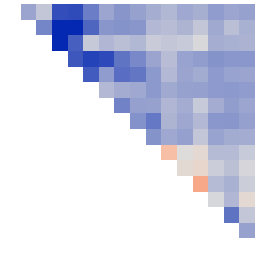

In [140]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

#cmap = kde.plot.main.custom_diverging_cmap(low=SOM_BLUE, high=NNXR_GRAY)
cmap = modified_coolwarm_low(low=SOM_BLUE)
all_nnxo = [reb_rel_avgs[subject]['NNXo'] for subject in reb_rel_avgs.keys()]
all_nnxr = [reb_rel_avgs[subject]['NNXr'] for subject in reb_rel_avgs.keys()]
all_nnxo = acr.sync.average_sttc_matrices(all_nnxo)
all_nnxr = acr.sync.average_sttc_matrices(all_nnxr)

diffs = all_nnxo - all_nnxr
norm = TwoSlopeNorm(vmin=-0.08, vcenter=0, vmax=0.08)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(diffs, cmap=cmap, ax=ax, norm=norm, cbar=False)

fig_id = 'REBOUND_full_channel_map_all_subjects_NOSCALE'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

f.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight')

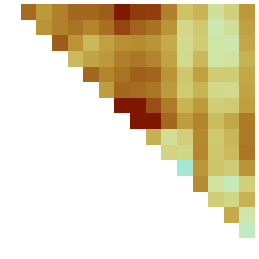

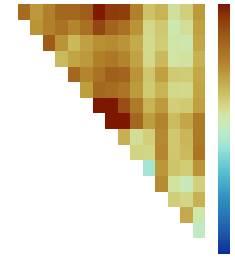

In [27]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_39'
probe = 'NNXr'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')

norm = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.1)
dat = reb_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 1.7]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

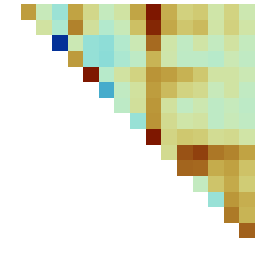

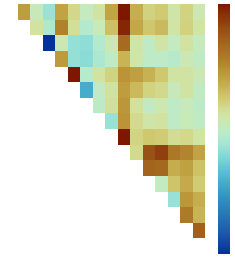

In [28]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_39'
probe = 'NNXo'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.1)
dat = reb_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 1.7]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

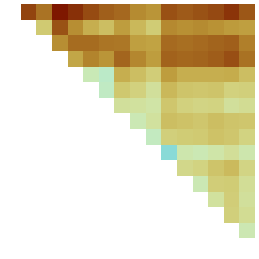

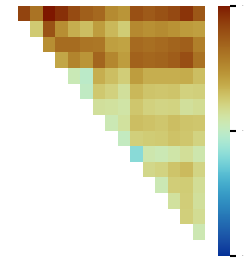

In [25]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_25'
probe = 'NNXr'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2.0)
dat = reb_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 2]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

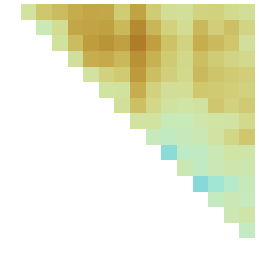

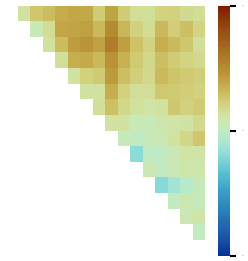

In [26]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_25'
probe = 'NNXo'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
dat = reb_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 2]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--rebound_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

# Matrix - Subject-by-Subject

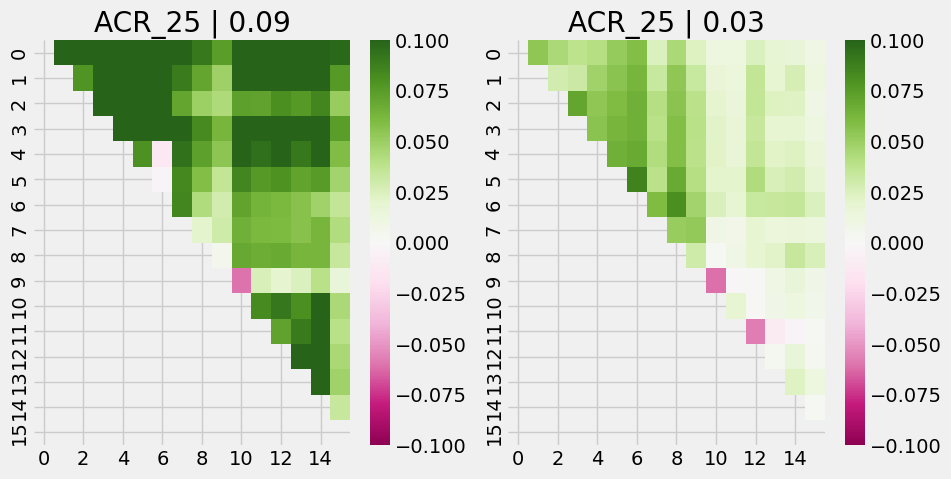

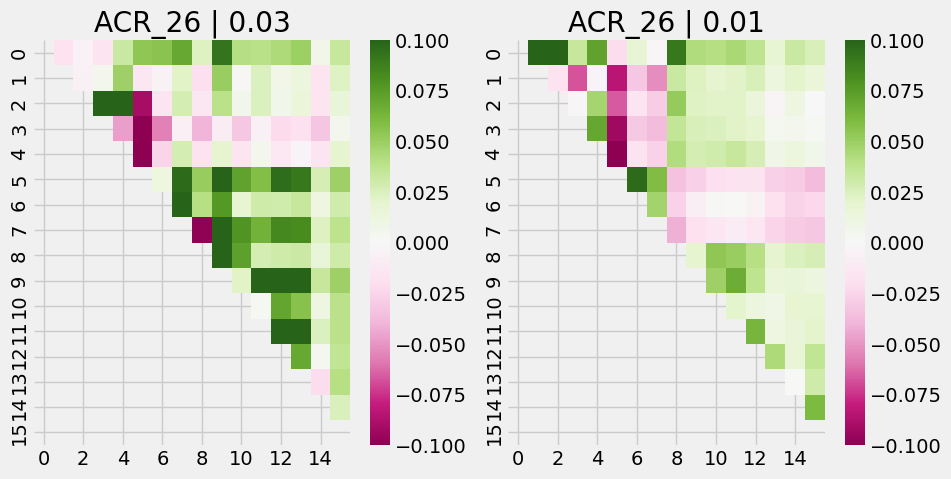

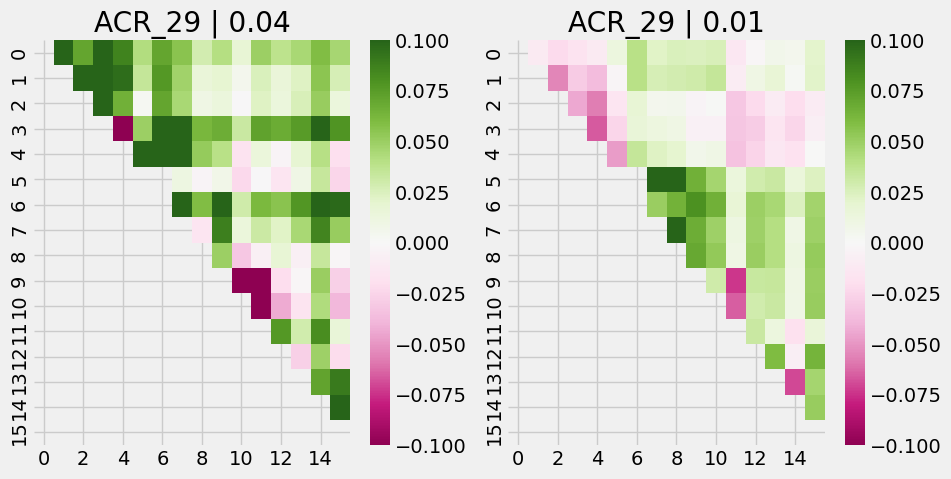

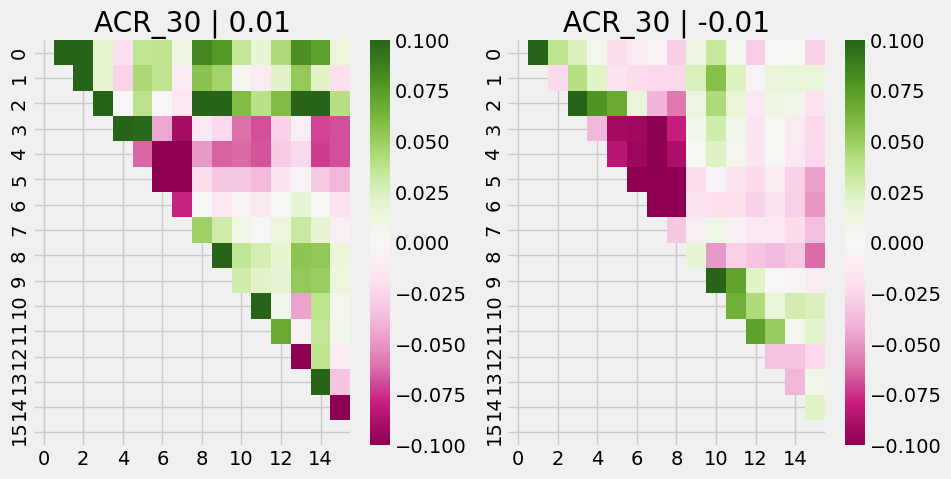

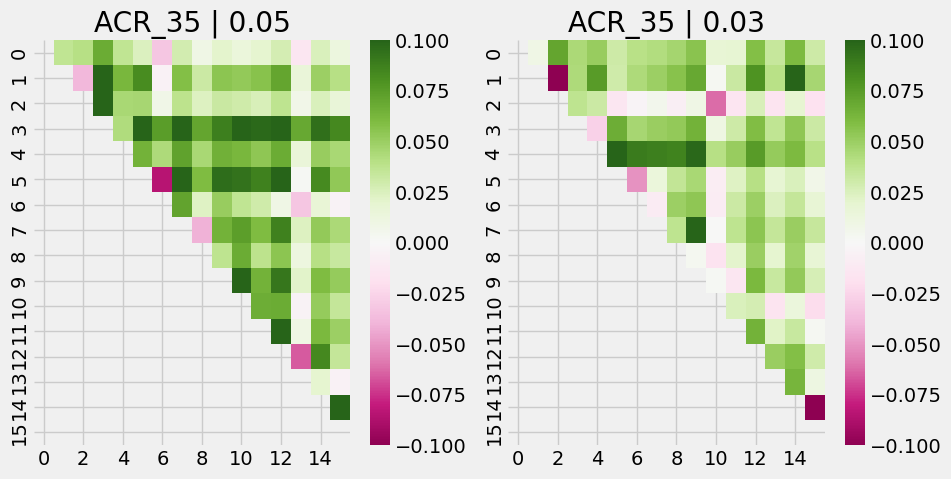

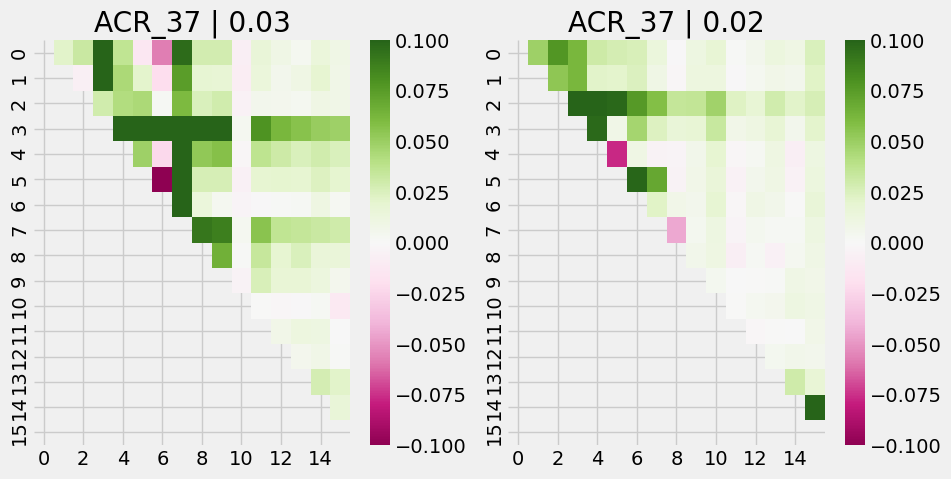

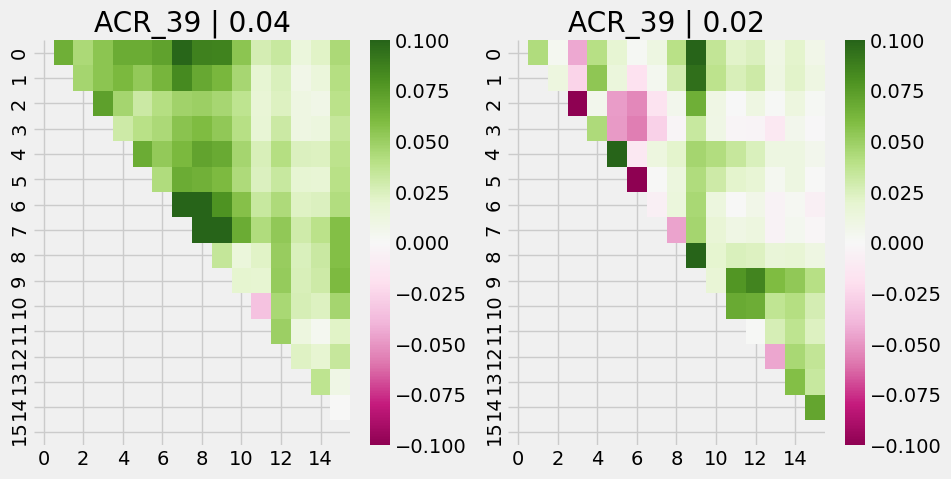

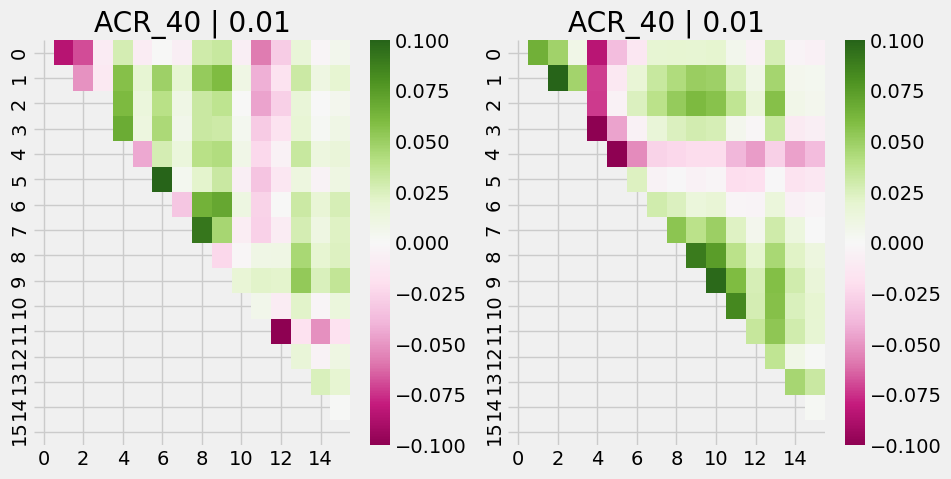

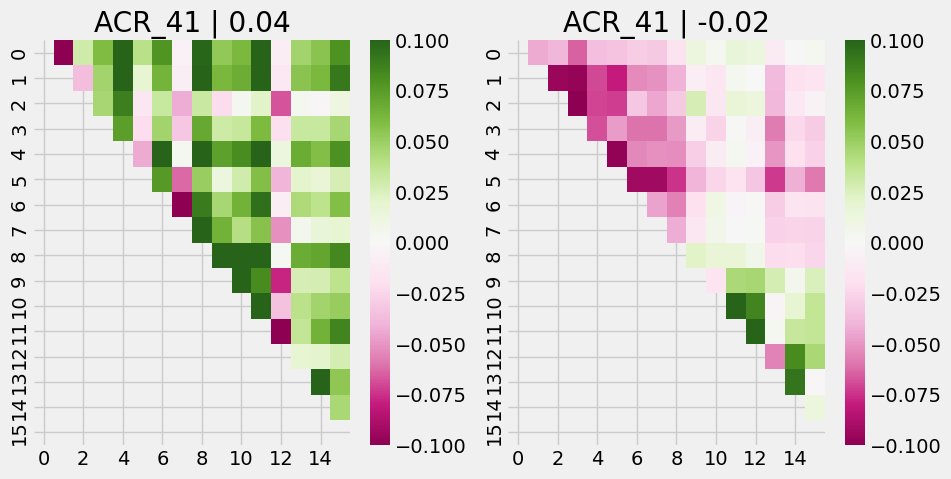

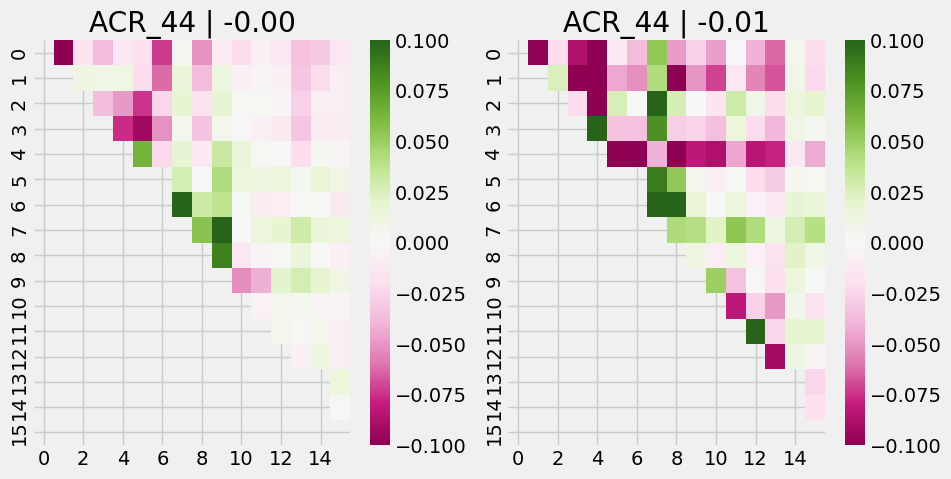

In [99]:
plt.rcdefaults()
plt.style.use('fivethirtyeight')
for subject in reb_rel_avgs.keys():
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(reb_rel_avgs[subject]['NNXr'], cmap='PiYG', ax=ax[0],
                vmin=-0.1, vmax=0.1
                )
    ax[0].set_title(f'{subject} | {np.nanmean(reb_rel_avgs[subject]["NNXr"]):.2f}')
    sns.heatmap(reb_rel_avgs[subject]['NNXo'], cmap='PiYG', ax=ax[1], 
                vmin=-0.1, vmax=0.1
                )
    ax[1].set_title(f'{subject} | {np.nanmean(reb_rel_avgs[subject]["NNXo"]):.2f}')

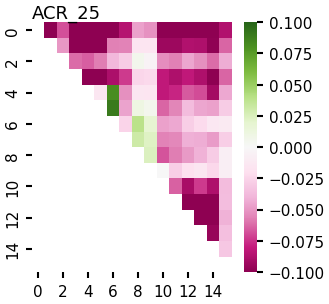

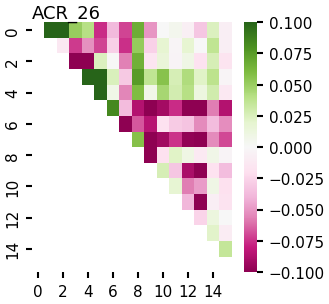

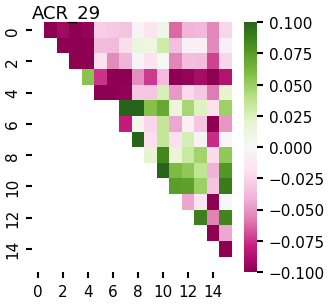

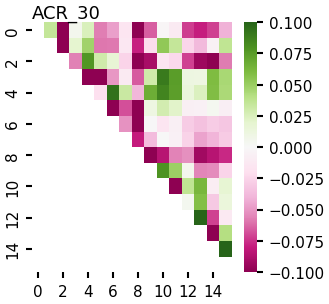

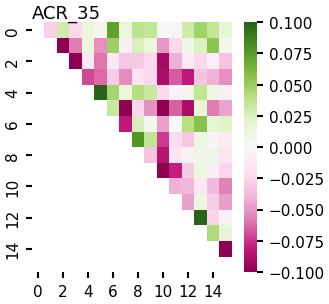

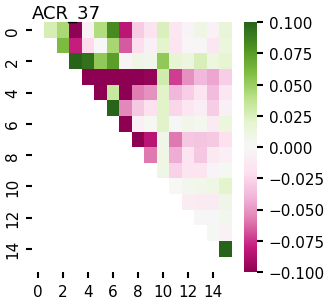

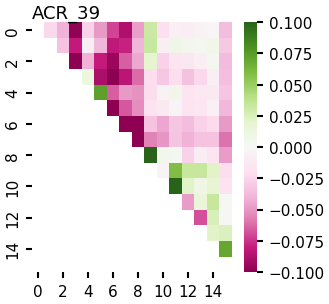

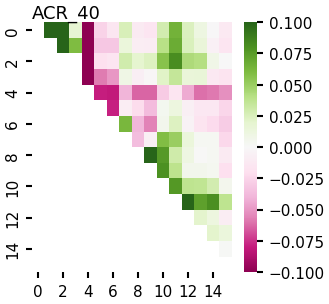

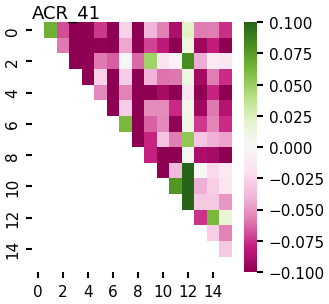

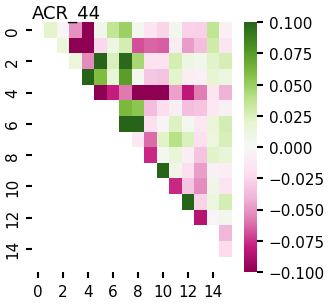

In [98]:
plt.rcdefaults()
acr.plots.supl()
for subject in reb_rel_avgs.keys():
    nnxr_dat = reb_rel_avgs[subject]['NNXr']
    nnxo_dat = reb_rel_avgs[subject]['NNXo']
    rel_dat = nnxo_dat-nnxr_dat
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(rel_dat, cmap='PiYG', ax=ax, vmin=-0.1, vmax=0.1)
    ax.set_title(subject)
    plt.show()

# Circ-BL

In [21]:
# make the averaged condition-matrices all relative to the full baseline - FISHER-transformed, difference
circ_rel_avgs = {}
for subject in bmtx.keys():
    circ_rel_avgs[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        full_bl_mtx = cond_avgs[subject]['full_bl'][probe]
        circ_mtx = cond_avgs[subject]['circ_bl'][probe]
        eps = 1e-6
        full_bl_mtx = np.arctanh(np.clip(full_bl_mtx, -1+eps, 1-eps))
        circ_mtx = np.arctanh(np.clip(circ_mtx, -1+eps, 1-eps))
        circ_mtx = circ_mtx - full_bl_mtx
        circ_rel_avgs[subject][probe] = circ_mtx

In [22]:
#obvious outlier/artifactual pairs
circ_rel_avgs['ACR_29']['NNXo'][5, 6] = np.nan
circ_rel_avgs['ACR_29']['NNXr'][5, 6] = np.nan

circ_rel_avgs['ACR_40']['NNXo'][2, 3] = np.nan
circ_rel_avgs['ACR_40']['NNXr'][2, 3] = np.nan

circ_rel_avgs['ACR_44']['NNXo'][5, 6] = np.nan
circ_rel_avgs['ACR_44']['NNXr'][5, 6] = np.nan
circ_rel_avgs['ACR_44']['NNXo'][13, 14] = np.nan
circ_rel_avgs['ACR_44']['NNXr'][13, 14] = np.nan

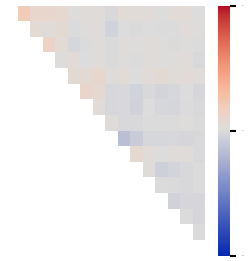

In [95]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

vmin = -0.08
vmax = 0.08

#cmap = kde.plot.main.custom_diverging_cmap(low=ACR_BLUE, high=NNXR_GRAY)
cmap = modified_coolwarm_low(low=MAIN_COLOR)

all_nnxo = [circ_rel_avgs[subject]['NNXo'] for subject in circ_rel_avgs.keys()]
all_nnxr = [circ_rel_avgs[subject]['NNXr'] for subject in circ_rel_avgs.keys()]
all_nnxo = acr.sync.average_sttc_matrices(all_nnxo)
all_nnxr = acr.sync.average_sttc_matrices(all_nnxr)

diffs = all_nnxo - all_nnxr
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(diffs, cmap=cmap, ax=ax, norm=norm, cbar_kws={'ticks': [vmin, 0, vmax]})

fig_id = 'CIRC-BL_full_channel_map_all_subjects'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

f.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight')

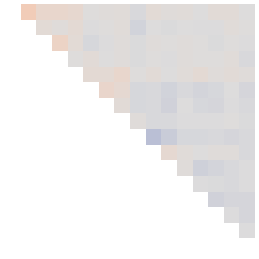

In [23]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

vmin = -0.08
vmax = 0.08

#cmap = kde.plot.main.custom_diverging_cmap(low=ACR_BLUE, high=NNXR_GRAY)
cmap = modified_coolwarm_low(low=MAIN_COLOR)

all_nnxo = [circ_rel_avgs[subject]['NNXo'] for subject in circ_rel_avgs.keys()]
all_nnxr = [circ_rel_avgs[subject]['NNXr'] for subject in circ_rel_avgs.keys()]
all_nnxo = acr.sync.average_sttc_matrices(all_nnxo)
all_nnxr = acr.sync.average_sttc_matrices(all_nnxr)

diffs = all_nnxo - all_nnxr
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(diffs, cmap=cmap, ax=ax, norm=norm, cbar=False)

fig_id = 'CIRC-BL_full_channel_map_all_subjects--NOSCALE'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

f.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight')

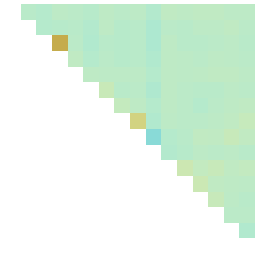

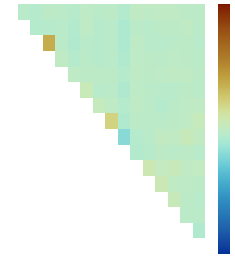

In [29]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_39'
probe = 'NNXo'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.1)
dat = circ_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 1.7]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

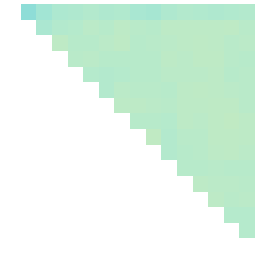

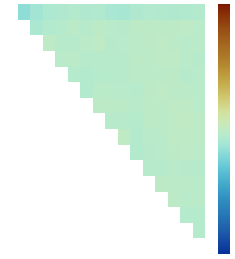

In [30]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_39'
probe = 'NNXr'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.1)
dat = circ_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 1.7]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

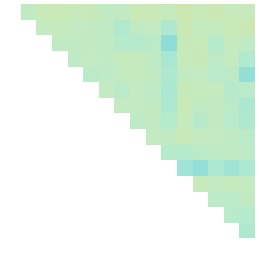

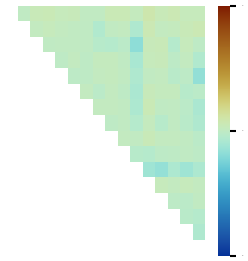

In [ ]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_25'
probe = 'NNXo'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
dat = circ_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 2]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

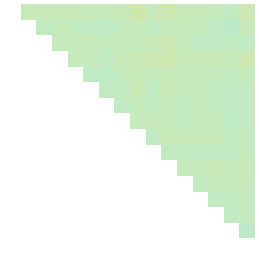

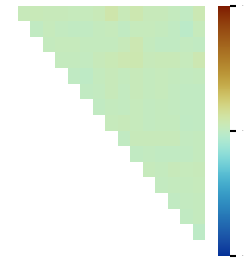

In [ ]:
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

subject = 'ACR_25'
probe = 'NNXr'

cmap = kde.plot.main.custom_diverging_cmap(low='firebrick', high='black')
norm = TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
dat = circ_rel_avgs[subject][probe]


f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar=False)
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map--NOSCALE.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(dat, cmap=scm.roma_r, ax=ax, norm=norm, cbar_kws={'ticks': [0.5, 1, 2]})
plt.savefig(f'{notebook_figure_root}/{subject}--{probe}--CIRC-BL_sttc_map.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

(0.9209759530511328, 1.0949004192368295)


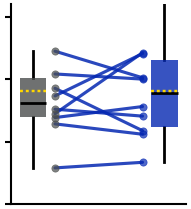

In [24]:
# better averaging method - first average each condition across bouts into a single matrix, then make each channel-pair value relative to its own channel-pair value from the baseline. Then average all of those channel-pairs into a single number.
plt.rcdefaults()
acr.plots.lrg()
plt.rcParams['xtick.bottom'] = False

fig_id = 'CIRC-BL_STTC_all_channel_average'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{notebook_figure_root}/{fig_name}.png'

nnxr = np.array([np.nanmean(circ_rel_avgs[subject]['NNXr']) for subject in circ_rel_avgs.keys()])
nnxo = np.array([np.nanmean(circ_rel_avgs[subject]['NNXo']) for subject in circ_rel_avgs.keys()])
nnxr = nnxr[~np.isnan(nnxr)]
nnxo = nnxo[~np.isnan(nnxo)]
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=(3.5, 4))
print(ax.get_ylim())
ax.set_yticks([0.9, 0.95, 1, 1.05])
ax.set_ylim(0.90, 1.06)
f.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

In [25]:
# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
#stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))

if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats

shapiro_p-value: 0.5191288175737938
d,agostino_p-value: 0.45742381650065533
hedges g: -0.005033418113061182


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.026731,9,two-sided,0.979258,"[-0.02, 0.02]",0.005255,0.309,0.050026


# By Depth

In [143]:
acr.plots.supl()
nbroot = f'{acr.utils.PAPER_FIGURE_ROOT}/synchrony/sttc/by_depth'

In [144]:
# Convert STTC matrix to dataframe with channel pairs
def mtx_to_df(mtx):
    sttc_df_list = []
    for i in range(mtx.shape[0]):
        for j in range(mtx.shape[1]):
            if i != j and not np.isnan(mtx[i, j]):  # Skip diagonal and NaN values
                sttc_df_list.append({
                    'sttc_value': mtx[i, j],
                    'channel_1': i+1,
                    'channel_2': j+1
                })

    sttc_df = pl.DataFrame(sttc_df_list)
    return sttc_df

In [145]:
dfs = []
for subject in reb_rel_avgs.keys():
    for probe in ['NNXo', 'NNXr']:
        avg_mtx = reb_rel_avgs[subject][probe]
        df = mtx_to_df(avg_mtx)
        df = df.with_columns(pl.lit(probe).alias('probe'))
        df = df.with_columns(pl.lit(subject).alias('subject'))
        dfs.append(df)

mxdf = pl.concat(dfs)

In [ ]:
mxdf = acr.info_pipeline.label_df_sub_infra(mxdf, chan_col='channel_1', label_col='label_1', join_on=['subject', 'probe', 'channel_1'])
mxdf = acr.info_pipeline.label_df_sub_infra(mxdf, chan_col='channel_2', label_col='label_2', join_on=['subject', 'probe', 'channel_2'])
mxdf

shapiro_p-value: 0.35090065549700855
d,agostino_p-value: 0.5906751422446603
hedges g: 1.0055538778262003


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.339592,9,two-sided,0.008666,"[0.02, 0.1]",1.049917,6.954,0.839252


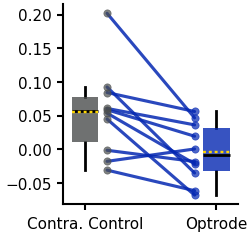

In [148]:
# INFRA - INFRA
fig_id = f'STTC_by_depth__infra-infra'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'infragranular').filter(pl.col('label_2') == 'infragranular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats


shapiro_p-value: 0.10315962078242269
hedges g: 0.4357352005301708


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.958013,6,two-sided,0.37505,"[-0.04, 0.08]",0.465444,0.506,0.180854


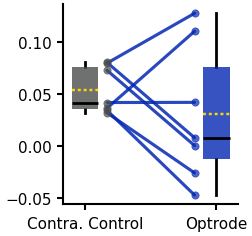

In [149]:
# GRAN - GRAN
fig_id = f'STTC_by_depth__gran-gran'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'granular').filter(pl.col('label_2') == 'granular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats


shapiro_p-value: 0.9936161546760534
hedges g: 0.1981997337784615


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.590594,9,two-sided,0.569324,"[-0.01, 0.02]",0.206944,0.358,0.090362


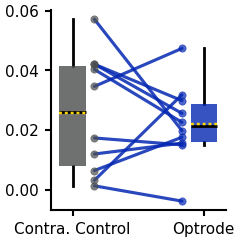

In [150]:
# SUB - SUB
fig_id = f'STTC_by_depth__sub-sub'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'subgranular').filter(pl.col('label_2') == 'subgranular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats


shapiro_p-value: 0.2771382736861451
hedges g: 0.9886419966243595


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.397954,6,two-sided,0.014533,"[0.01, 0.06]",1.056049,5.037,0.646497


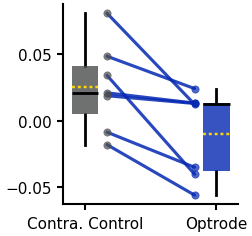

In [153]:
# INFRA - GRAN
fig_id = f'STTC_by_depth__infra-gran'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'infragranular').filter(pl.col('label_2') == 'granular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats


shapiro_p-value: 0.16531189268642082
hedges g: 0.8718049046368392


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.162302,9,two-sided,0.011508,"[0.01, 0.04]",0.910267,5.541,0.726774


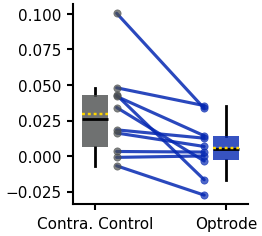

In [154]:
# INFRA - SUB
fig_id = f'STTC_by_depth__infra-sub'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'infragranular').filter(pl.col('label_2') == 'subgranular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
#stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    #acr.stats.write_stats_result(stats_name, 'wilcoxon', stats['W-val'][0], stats['p-val'][0], 'r, RBC', [r, stats['RBC'][0]])
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats


shapiro_p-value: 0.4997900194943541
hedges g: 0.7103835433393283


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.446808,6,two-sided,0.198098,"[-0.01, 0.04]",0.758819,0.751,0.393489


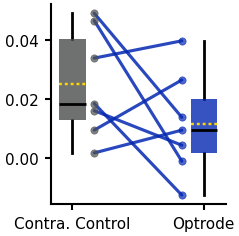

In [155]:
# gran - SUB
fig_id = f'STTC_by_depth__gran-sub'
fig_name = f'{SUBJECT_TYPE}__{MAIN_EXP}__{fig_id}'
fig_path = f'{nbroot}/{fig_name}.png'

filtdf = mxdf.filter(pl.col('label_1') == 'granular').filter(pl.col('label_2') == 'subgranular')
filtavg = filtdf.group_by(['subject', 'probe']).agg(pl.mean('sttc_value')).sort('subject', 'probe')
nnxo = filtavg.filter(pl.col('probe') == 'NNXo')['sttc_value'].to_numpy()
nnxr = filtavg.filter(pl.col('probe') == 'NNXr')['sttc_value'].to_numpy()
f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo)
ax.set_xticklabels(['Contra. Control', 'Optrode'])
plt.savefig(fig_path, dpi=600, bbox_inches='tight', transparent=True)

# =============================
# ========== STATS ============
# =============================
write = True

diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
#stats = pg.wilcoxon(nnxr, nnxo)

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))


if write:
    # ==== Write Stats Results ====
    stats_name = f'{fig_name}'
    acr.stats.write_stats_result(stats_name, 'paired_ttest', stats['T'][0], stats['p-val'][0], 'g', hg)
    #acr.stats.write_stats_result(stats_name, 'wilcoxon', stats['W-val'][0], stats['p-val'][0], 'r, RBC', [r, stats['RBC'][0]])
    
    # ===== Write Source Data =====
    source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
    pu.write_source_data(source_data, stats_name)
stats